In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [3]:
dftrain = pd.read_csv("data/plasticc_train_metadata.csv")

dftest = pd.read_csv("data/plasticc_test_metadata.csv")

dftest = dftest[:20000]

dftest['target'] = dftest['true_target']

dftrain = pd.concat([dftrain, dftest], axis=0, ignore_index=True)

model_nums = {90:'SN Ia', 67:'SNIa-91bg', 52:'SNIax', 42:'SNII', 62:'SNIbc', 95:'SLSN-I', 15:'TDE', 64:'KN', 88:'AGN', 92:'RRL', 65:'M-dwarf', 16:'EB', 53:'Mira', 6:'muLens-Single', 991:'muLens-Binary', 992:'ILOT', 993:'CaRT', 994:'PISN', 995:'muLens-String'}

sn_models = [90, 67, 52, 42, 62, 95, 15]

dftrain = dftrain[dftrain['target'].isin(sn_models)]

dftrain['target_names'] = dftrain['target'].map(model_nums)

In [6]:
lcs = pd.read_csv("data/plasticc_train_lightcurves.csv")
lcs_test = pd.read_csv("data/plasticc_test_lightcurves_01.csv")

lcs = pd.concat([lcs, lcs_test[:3000000]], axis=0, ignore_index=True)

# lcs = pd.merge(lcs, dftrain, on='object_id', how='inner')
# lcs['passband']

In [8]:
columns = ['object_id', 'mjd', 'passband', 'flux', 'flux_err']
columns2 = ['mjd', 'passband', 'flux', 'flux_err']
# filter wavelengths in angstroms
wavelengths = {
    0: 3671.0,
    1: 4827.0,
    2: 6223.0,
    3: 7546.0,
    4: 8691.0,
    5: 9712.0
}

lcs['passband'] = lcs['passband'].map(wavelengths)

In [9]:
# Prepare Train Data
x_data = []
y_data = []

max_length = 352

for id in dftrain['object_id']:
    if len(lcs[lcs['object_id'] == id]) == 0:
        continue
    x_data.append(lcs[lcs['object_id'] == id][columns].reset_index())
    y_data.append(dftrain[dftrain['object_id'] == id][['object_id', 'true_peakmjd']].values.tolist()[0])

    # Expand light curve data to max length with 0s
    while len(x_data[-1].index) < max_length: 
        x_data[-1].loc[len(x_data[-1].index)] = [len(x_data[-1].index), id, 0, 0, 0, 0]
    x_data[-1] = x_data[-1][columns]


In [10]:
# Normalize Data
for i in range(len(x_data)):
    # try:
    #     x_train[i] = x_train[i].values
    # except AttributeError:
    #     pass
    y_data[i][1] -= 58999
    y_data[i][1] /= 2000
    for j in range(len(x_data[i])):
        if x_data[i].loc[j]['mjd'] == 0:
            continue
        x_data[i].at[j, 'mjd'] -= 59000
        x_data[i].at[j, 'mjd'] /= 2000
        x_data[i].at[j, 'passband'] -= 3670
        x_data[i].at[j, 'passband'] /= 6041

In [11]:
x_train, x_test, y_train, y_test = train_test_split(
     x_data, y_data, test_size=0.2, random_state=42)

In [12]:
x_test, x_val, y_test, y_val = train_test_split(
    x_test, y_test, test_size=0.5, random_state=45)

In [15]:

# print(x_train)
x_train_values = []
for i in range(len(x_train)):
    x_train_values.append([])
    for row in x_train[i].values:
        x_train_values[-1].append(row[1:])
y_train_values = [np.array(y[1]) for y in y_train]

x_test_values = []
for i in range(len(x_test)):
    x_test_values.append([])
    for row in x_test[i].values:
        x_test_values[-1].append(row[1:])
y_test_values = [np.array(y[1]) for y in y_test]

x_val_values = []
for i in range(len(x_val)):
    x_val_values.append([])
    for row in x_val[i].values:
        x_val_values[-1].append(row[1:])
y_val_values = [np.array(y[1]) for y in y_val]

In [19]:
# Build Model

import tensorflow as tf
# import tensorflow_probability as tfp

tf.random.set_seed(1)

model = tf.keras.Sequential([
    tf.keras.layers.Input((352, 4)),
    tf.keras.layers.Masking(mask_value=0.0),
    tf.keras.layers.GRU(50, return_sequences=True, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(50,activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')])
    # tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t[..., :1],
                           #scale=1e-3 + tf.math.softplus(0.05 * t[...,1:])))])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),loss='mean_squared_error')

In [20]:
print(len(x_train_values), len(y_train_values))

11132 11132


In [21]:
### Train Model
model.fit(np.array(x_train_values), np.array(y_train_values), epochs=1, validation_data=(np.array(x_val_values), np.array(y_val_values)))



348/348 ━━━━━━━━━━━━━━━━━━━━ 60s 166ms/step - loss: 0.0141 - val_loss: 0.0033


In [22]:
model.save('model.keras')

In [23]:
import pickle

with open('x_test_values.pickle', 'wb') as file:
    pickle.dump(x_test_values, file)

with open('y_test.pickle', 'wb') as file:
    pickle.dump(y_test, file)

In [24]:
print(np.array(x_test_values).shape)
y_pred = model.predict(np.array(x_test_values))

(1392, 352, 4)
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


In [25]:
model2 = tf.keras.models.load_model('model.keras')
y_pred = model2.predict(np.array(x_test_values))

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


In [26]:
print(np.array(x_test_values).shape)
print(model.layers[0].mask_value)

(1392, 352, 4)
0.0


In [27]:
def display_object(object_id, lightcurve_data, metadata, predicted=0):
    lightcurve_data = lightcurve_data[lightcurve_data['object_id'] == object_id]
    passbands = []
    true_peaktime = metadata[metadata['object_id'] == object_id]['true_peakmjd']
    print(true_peaktime)

    for freq in range(6):
        passbands.append(lightcurve_data[lightcurve_data['passband'] == freq][['mjd', 'flux']])

    for p in passbands:
        plt.scatter(p['mjd'], p['flux'])
        print(true_peaktime)
        plt.scatter(true_peaktime, [0])
        if predicted > 0:
            plt.scatter([predicted], [0])
        

    plt.xlabel("Modified Julien Date")

    plt.ylabel("Flux")
    
    plt.show()


16879    60386.324
Name: true_peakmjd, dtype: float64
16879    60386.324
Name: true_peakmjd, dtype: float64
16879    60386.324
Name: true_peakmjd, dtype: float64
16879    60386.324
Name: true_peakmjd, dtype: float64
16879    60386.324
Name: true_peakmjd, dtype: float64
16879    60386.324
Name: true_peakmjd, dtype: float64
16879    60386.324
Name: true_peakmjd, dtype: float64


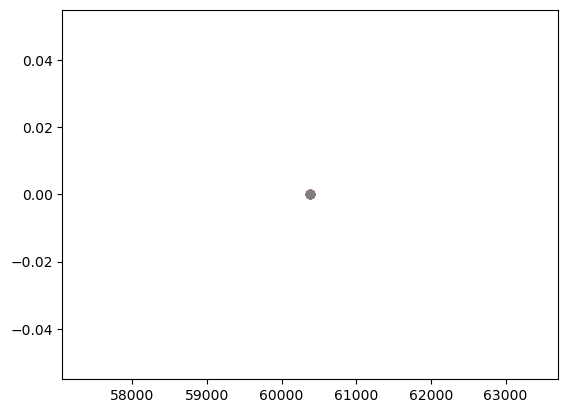

In [28]:
display_object(95564, lcs, dftrain, 0.6931620000000003*2000+59000)